# Image load

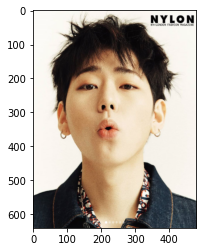

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/zico2.png'
#opencv로 이미지를 읽기
img_bgr = cv.imread(my_image_path)
#image resize
img_bgr = cv.resize(img_bgr, (480, 640))
#이미지 리사이즈를 잘못 된 비율로 하여 얼굴이 짜그러지면 네모 박스로 인식을 하지 못함.

#opencv는 BGR순으로 사용. 때문에 색이 파랗게 보임. 
#원본으로 보려면 RGB로 바꿔줘야함.
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

#출력용 이미지 별도 보관
img_show = img_bgr.copy()

#이미지 출력
plt.imshow(img_rgb)
plt.show()

# Face landmark

rectangles[[(82, 171) (349, 439)]]


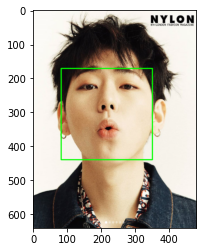

In [2]:
import dlib

#detector 선언
detector_hog = dlib.get_frontal_face_detector()   

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
#(image, num of img pyramid)
dlib_rects = detector_hog(img_rgb, 1)   

#찾은 얼굴영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


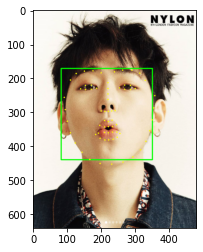

In [3]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

#RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [4]:
#얼굴 좌표
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #nose center index : 30
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(219, 262)
(x,y) : (219,262)
(w,h) : (268,268)


# 스티커 파일 load

(268, 268, 3)


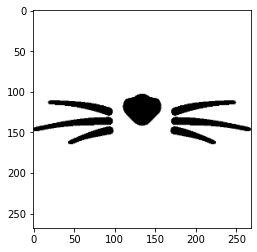

In [5]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv.imread(sticker_path)
img_sticker = cv.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

In [6]:
#원본에서 스티커가 붙을 위치 구하기

refined_x = x - w // 2  # left
refined_y = y - h //2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (85,128)


# np.where 사용하여 스티커 붙이기
- png 파일임에도 불구하고 투명 배경이 아니라 흰 배경이 나와서 스티커의 역할을 제대로 하지 못했었음.
- 두가지 방법으로 해결 해 봄.

### np.where(img_sticker == 0, img_sticker, sticker_area)
- 기존에는 np.where(img_sticker == 0, sticker_area, img_sticker)로 왕관 스티커를 붙였으나 해당 스티커에서는 sticker_area, img_sticker의 위치를 바꾸어서 스티커를 붙임.

### np.where(img_sticker == 255, sticker_area, img_sticker)
- img_sticker == 0 에서 255로 바꾸어서 흰 배경을 없애는 방법으로 스티커를 붙임.

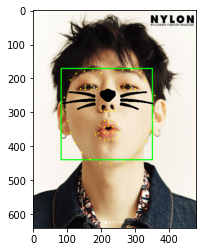

In [7]:
#np.where(img_sticker == 0, img_sticker, sticker_area) 방법

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 0, img_sticker, sticker_area).astype(np.uint8)

#스티커+랜드마크 결과 이미지
plt.imshow(cv.cvtColor(img_show, cv.COLOR_BGR2RGB))
plt.show()

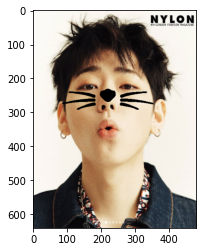

In [8]:
#랜드마크 제외하고 출력하기

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker== 0,img_sticker,sticker_area).astype(np.uint8)

#최종 결과 이미지 출력
plt.imshow(cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)) 

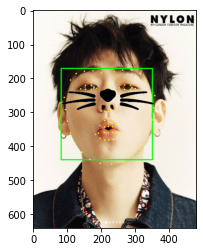

In [9]:
#np.where(img_sticker == 255, sticker_area, img_sticker) 방법

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)

#스티커+랜드마크 결과 이미지
plt.imshow(cv.cvtColor(img_show, cv.COLOR_BGR2RGB))
plt.show()

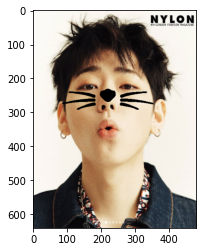

In [11]:
#랜드마크 제외하고 출력하기

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)

#최종 결과 이미지 출력
plt.imshow(cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB))
plt.show()

# 스티커의 좌표를 계산한 기준
- 고양이 수염에서 코 부분이 원본 사진의 코 좌표와 같아야 한다고 판단했다.
- 때문에 코의 중심 인덱스가 30인 것을 알고 있기에 x = landmark[30][0], y = landmark[30][1]로 얼굴 좌표를 계산했다.
- 스티커가 붙을 좌표는 이미지의 시작점은 x에서 너비의 1/2를 뺀 값과 y에서 높이의 1/2를 뺀 좌표로 계산했다.

# 다양한 유형의 사진들 - 옆 모습

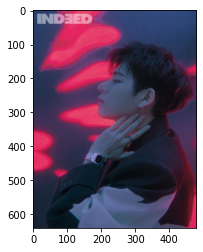

In [13]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/zico_side.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (480, 640))

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

#출력용 이미지 별도 보관
img_show = img_bgr.copy()

#이미지 출력
plt.imshow(img_rgb)
plt.show()

rectangles[]


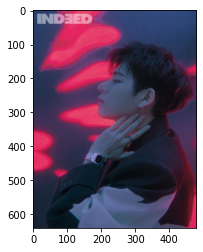

In [14]:
import dlib

#detector 선언
detector_hog = dlib.get_frontal_face_detector()   

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   

#찾은 얼굴영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 옆 모습의 사진
- 옆 모습의 사진에서는 얼굴을 인식을 하지 못해 초록색 박스조차 뜨지 않았다. 
- 얼굴의 전부가 보여야 인식을 할 수 있는데 절반도 안보여서 그런 것 같다.

# 다양한 유형의 사진들 -  얼굴이 일부 가려진 사진

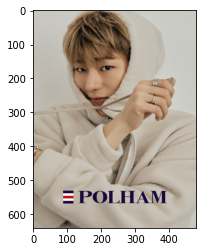

In [15]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/zico_hoody.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (480, 640))

#opencv는 BGR순으로 사용. RGB로 바꿔줘야함
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

#출력용 이미지 별도 보관
img_show = img_bgr.copy()

#이미지 출력
plt.imshow(img_rgb)
plt.show()

rectangles[]


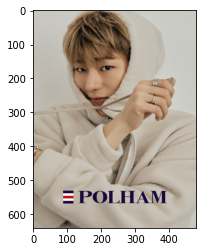

In [16]:
import dlib

#detector 선언
detector_hog = dlib.get_frontal_face_detector()   

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   

# 찾은 얼굴영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴 일부가 가려진 사진
- 눈, 코는 잘 보이지만 입 주변이 옷으로 가려져 있는 사진도 인식을 할까 궁금했다.
- 결론은 인식을 하지 못한다.
- 얼굴 윤곽도 옷으로 전부 가려져 있어서 그런 것 같다.

# 다양한 유형의 사진들 - 선글라스

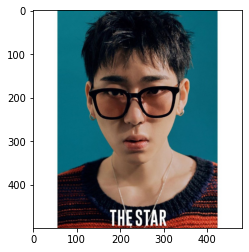

In [22]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/zico_glass.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (480, 500))

#opencv는 BGR순으로 사용. RGB로 바꿔줘야함
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

#출력용 이미지 별도 보관
img_show = img_bgr.copy()

#이미지 출력
plt.imshow(img_rgb)
plt.show()

rectangles[[(117, 118) (340, 341)]]


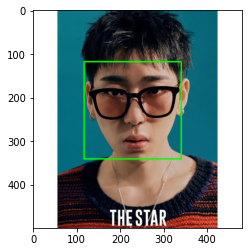

In [23]:
import dlib

#detector 선언
detector_hog = dlib.get_frontal_face_detector()   

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   

#찾은 얼굴영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


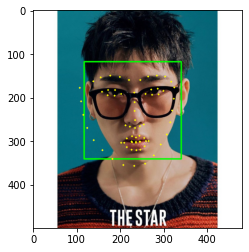

In [24]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

#RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [25]:
#얼굴 좌표
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) #nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(234, 252)
(x,y) : (234,252)
(w,h) : (224,224)


(224, 224, 3)


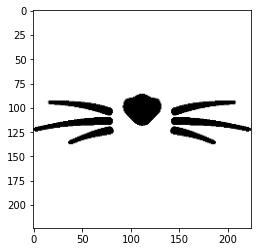

In [26]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv.imread(sticker_path)
img_sticker = cv.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

In [27]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (122,140)


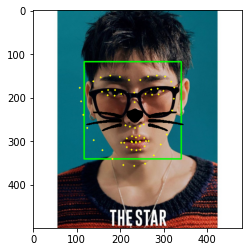

In [28]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 0, img_sticker, sticker_area).astype(np.uint8)

#스티커 + 랜드마크 결과 출력
plt.imshow(cv.cvtColor(img_show, cv.COLOR_BGR2RGB))
plt.show()

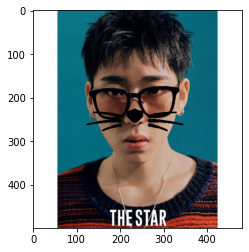

In [29]:
#랜드마크 제외 결과 출력

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker== 0,img_sticker,sticker_area).astype(np.uint8)

#최종 결과 이미지 출력
plt.imshow(cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB))
plt.show()

## 선글라스 낀 사진
- 선글라스를 껴서 눈이 조금 가려졌음에도 인식이 아주 잘 되었다. 
- 때문에 스티커 또한 제 위치에 잘 붙었다.

# 다양한 유형의 사진들 - 비스듬한 각도 + 약간의 거리

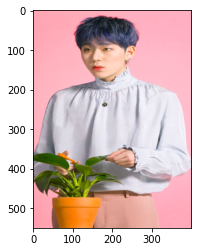

In [33]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/zico_pink.png'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (400, 550))

#opencv는 BGR순으로 사용. RGB로 바꿔줘야함
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

#출력용 이미지 별도 보관
img_show = img_bgr.copy()

#이미지 출력
plt.imshow(img_rgb)
plt.show()

rectangles[[(96, 53) (225, 182)]]


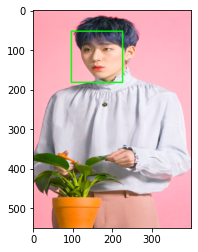

In [34]:
import dlib

#detector 선언
detector_hog = dlib.get_frontal_face_detector()   

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   

# 찾은 얼굴영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


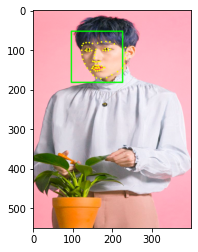

In [35]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

#RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [36]:
#얼굴 좌표
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) #nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(154, 121)
(x,y) : (154,121)
(w,h) : (130,130)


(130, 130, 3)


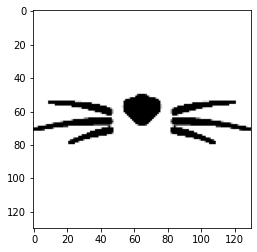

In [37]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv.imread(sticker_path)
img_sticker = cv.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

In [38]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (89,56)


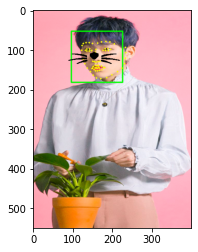

In [39]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 0, img_sticker, sticker_area).astype(np.uint8)

#스티커 + 랜드마크 결과 이미지 출력
plt.imshow(cv.cvtColor(img_show, cv.COLOR_BGR2RGB))
plt.show()

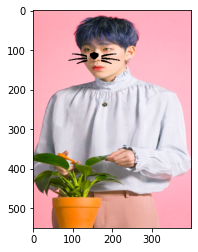

In [40]:
#랜드마크 제외한 결과 출력

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker== 0,img_sticker,sticker_area).astype(np.uint8)

#최종 결과 이미지 출력
plt.imshow(cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)) 
plt.show()

## 비스듬한 각도 + 거리가 약간 있는 사진
- 아예 옆 모습은 아니지만 비스듬한 각도임에도 얼굴 인식이 잘 되어 스티커 또한 제 위치에 잘 붙었다.
- 이전 사진들과 달리 거리가 약간 있음에도 얼굴 인식이 잘 되었다.

# 다양한 유형의 사진들 - 여러명일 때(2명)

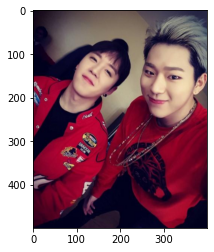

In [43]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/two.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (400, 500))

#opencv는 BGR순으로 사용. RGB로 바꿔줘야함
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

#출력용 이미지 별도 보관
img_show = img_bgr.copy()

#이미지 출력
plt.imshow(img_rgb)
plt.show()

rectangles[[(218, 98) (373, 253)], [(91, 92) (199, 199)]]


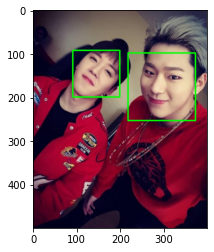

In [44]:
import dlib

#detector 선언
detector_hog = dlib.get_frontal_face_detector()   

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   

# 찾은 얼굴영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


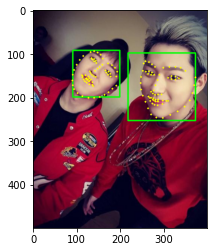

In [45]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

#RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


#for landmark in list_landmarks:
#    for idx, point in enumerate(list_points):
for landmark in list_landmarks: 
    for idx, point in enumerate(landmark):
        cv.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [50]:
#얼굴 좌표
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(277, 184)
(x,y) : (277,184)
(w,h) : (156,156)
(142, 139)
(x,y) : (142,139)
(w,h) : (109,109)


(109, 109, 3)


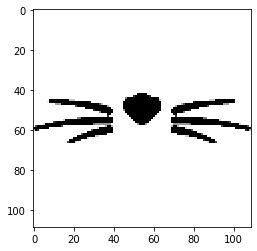

In [54]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv.imread(sticker_path)
img_sticker = cv.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

In [57]:
refined_x = x - w // 2  # left
refined_y = y + h //2   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (88,193)
(x,y) : (88,0)


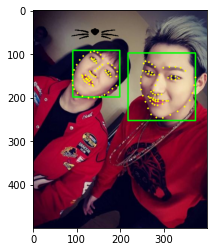

In [58]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 0, img_sticker, sticker_area).astype(np.uint8)

#스티커 + 랜드마크 결과 출력
plt.imshow(cv.cvtColor(img_show, cv.COLOR_BGR2RGB))
plt.show()

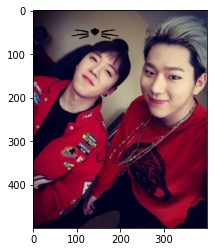

In [59]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker== 0,img_sticker,sticker_area).astype(np.uint8)

#최종 결과 이미지 출력
plt.imshow(cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB))
plt.show()

## 두 명이 있는 사진
- 두 얼굴이 한번에 인식이 될까?
- 결론은 Yes.
- 두 얼굴 모두 인식이 되어 랜드마크까지 깔끔하게 찍힌다.
- 하지만 스티커의 좌표를 구할 때 한 얼굴에 대한 좌표와만 계산이 되어 스티커는 한 얼굴에만 붙는다.
- 마지막으로 계산 된 얼굴의 좌표에 맞게 스티커 좌표가 설정 되어서 엉뚱한 곳에 붙게 되었다.
- 여러 좌표에 대해 스티커의 좌표도 계산할 수 있도록 코드 수정이 필요하다고 생각한다.

# 다양한 유형의 사진들 - 여러명일 때(2명 이상)

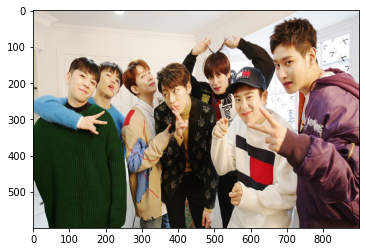

In [63]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/bb.jpg'
img_bgr = cv.imread(my_image_path)
img_bgr = cv.resize(img_bgr, (900, 600))

#opencv는 BGR순으로 사용. RGB로 바꿔줘야함
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

#출력용 이미지 별도 보관
img_show = img_bgr.copy()

#이미지 출력
plt.imshow(img_rgb)
plt.show()

rectangles[[(104, 171) (179, 246)], [(534, 216) (623, 305)], [(643, 116) (733, 206)], [(287, 156) (349, 218)]]


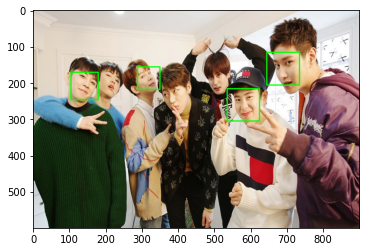

In [64]:
import dlib

#detector 선언
detector_hog = dlib.get_frontal_face_detector()   

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   

# 찾은 얼굴영역 좌표
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv.LINE_AA)

img_show_rgb =  cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


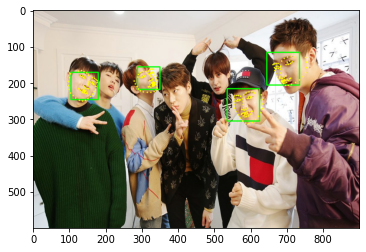

In [65]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

#RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


#for landmark in list_landmarks:
#    for idx, point in enumerate(list_points):
for landmark in list_landmarks: 
    for idx, point in enumerate(landmark):
        cv.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv.cvtColor(img_show, cv.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 두 명 이상이 있는 사진
- 해당 사진에는 총 7명의 얼굴이 있지만 전부 인식이 되지는 않았다.
- 너무 멀리 있거나, 얼굴의 각도가 인식하기 어려웠거나, 무언가에 얼굴이 가려졌기 때문이라고 판단했다.
- 두 명일 때의 코드와 마찬가지로 스티커가 각 얼굴의 좌표에 맞게 계산되어야 하기 때문에 스티커를 붙이는 작업까진 하지 않았다.